# TF DEV Summit - TF.DATA - Modu Labs

# 발표자 소개

 - 모두의 연구소 Deep NLP
 
 - CompanyAI Deep Learning Engineer (챗봇)
 
 - Contact Info: sungjin7127@gmail.com

# 시작하기 전에....

# Background - Dynamic vs. Static

- http://stackabuse.com/python-generators/ 

- http://pymbook.readthedocs.io/en/latest/igd.htm

- https://dojang.io/mod/page/view.php?id=1117

##  Iterator - Repeatable Object (반복가능한 객체)

## Generator - Iterator를 만들어주는 것, lazy generation of values (on-demand)

## Yield - 함수에서 return과 동일한 역할 수행

 1. 온디멘드 방식으로 메모리를 적게 사용 (Streaming, Big Data)
 2. 사용하지 않는 값들은 저장하고 있지 않음
 

In [35]:
#동적 데이터 관리 예제

#Generator
#yield: 함수 실행 중간에 빠져나올 수 있는 generator를 만들 때 사용

def numberGenerator(n):
    number = 0
    while number < n:
        yield number
        number += 1
        
myGenerator = numberGenerator(3)

print("동적 데이터의 예")
print(next(myGenerator))
print(next(myGenerator))  
print(next(myGenerator))

#정적으로 변환하려면? list

print("정적 변환 {}".format(list(numberGenerator(5))))

동적 데이터의 예
0
1
2
정적 변환 [0, 1, 2, 3, 4]


In [36]:
def generator(n):
    print("get_START")
    i = 0
    while i < n:
        yield i
        print("yield 이후 %d" % i)
        i += 1
    print("get_END")

for i in generator(4):
    print("for_START %d" % i)
    print(i)
    print("for_END %d" % i)

get_START
for_START 0
0
for_END 0
yield 이후 0
for_START 1
1
for_END 1
yield 이후 1
for_START 2
2
for_END 2
yield 이후 2
for_START 3
3
for_END 3
yield 이후 3
get_END


## TF의 시작, 결국 데이터를 빠르고, 쉽게 다루는 것이 핵심

## **The tf.data mission**

Input piplines for Tensorflow should be:

**Fast** : to keep up with GPUs and TPUs

**Flexible** : to handle diverse data sources and use cases

**Easy to use** : to democratize machine learning

## Extract Transform Load for Tensorflow

```python
#Extract
files = tf.data.Dataset.list_files(file_pattern)
dataset = tf.data.TFRecordDataset(files)

#Transform
dataset = dataset.shuffle(10000)
dataset = dataset.repeat(NUM_EPOCHS)
dataset = dataset.map(lambda x: tf.parse_single_example(x, features))
dataset = dataset.batch(BATCH_SIZE)

#Load
iterator = dataset.make_one_shot_iterator() #Sequencial Access
features = iterator.get_next()
```

## Performance

- CNN benchmarks reach > **13,000 images/second** with tf.data -> 8달 전과 비교하여 성능 2배 성장 (DGX - Imagenet)
 <br />
- 텐서플로우 벤치마크 프로젝트를 사용하여 활용: www.tensorflow.org/performance/datasets_performance

- New tf.contrib.data.prefetch_to_device() for GPUs tf 1.8 (tf-nightly에 보유)

- https://www.tensorflow.org/versions/master/performance/datasets_performance

```python

## 속도를 올리기 위해서는?? Parallel!!

#Extract
files = tf.data.Dataset.list_files(file_pattern)
# dataset = tf.data.TFRecordDataset(files) ->
dataset = tf.data.TFRecordDataset(files, num_parallel_reads=32)

#Transform

#shuffle_and_repeat: epochs와 buffers사이에서 정지하는 현상 방지
dataset = dataset.apply(
    tf.contrib.data.shuffle_and_repeat(10000, NUM_EPOCHS))

#map_and_batch: map과 data transfer를 동시에 함
dataset = dataset.apply(
    tf.contrib.data.map_and_batch(lambda x: ..., BATCH_SIZE))

#Load

#prefetch_to_device = 그 다음 batch가 미리 GPU 메모리 대기
dataset = dataset.apply(tf.contrib.data.prefetch_to_device("/gpu:0"))
iterator = dataset.make_one_shot_iterator() #Sequencial Access
features = iterator.get_next()

```

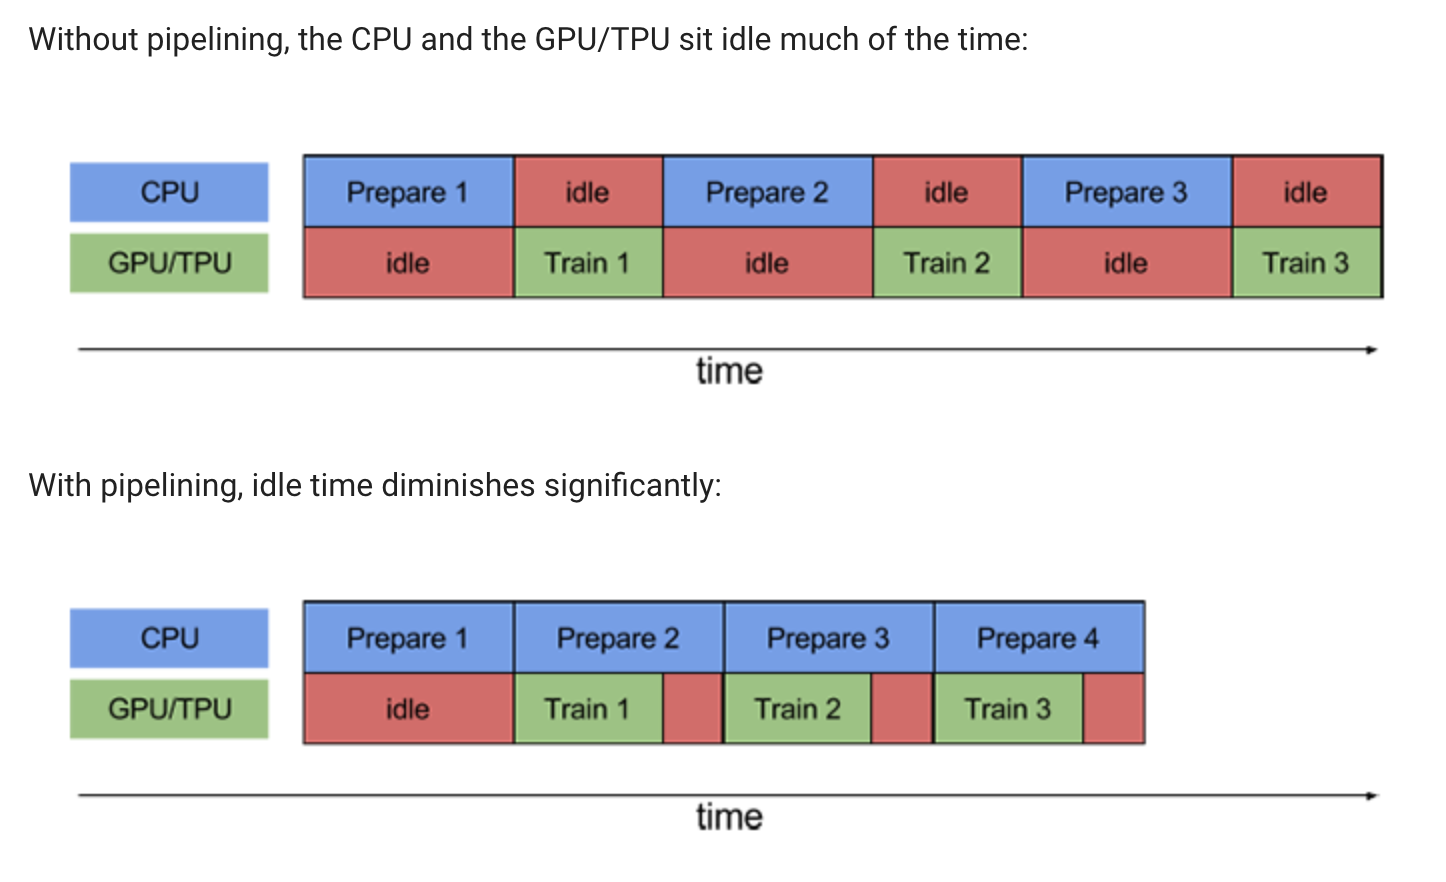

In [28]:
from IPython.display import Image
Image(filename='tf.data1.png')

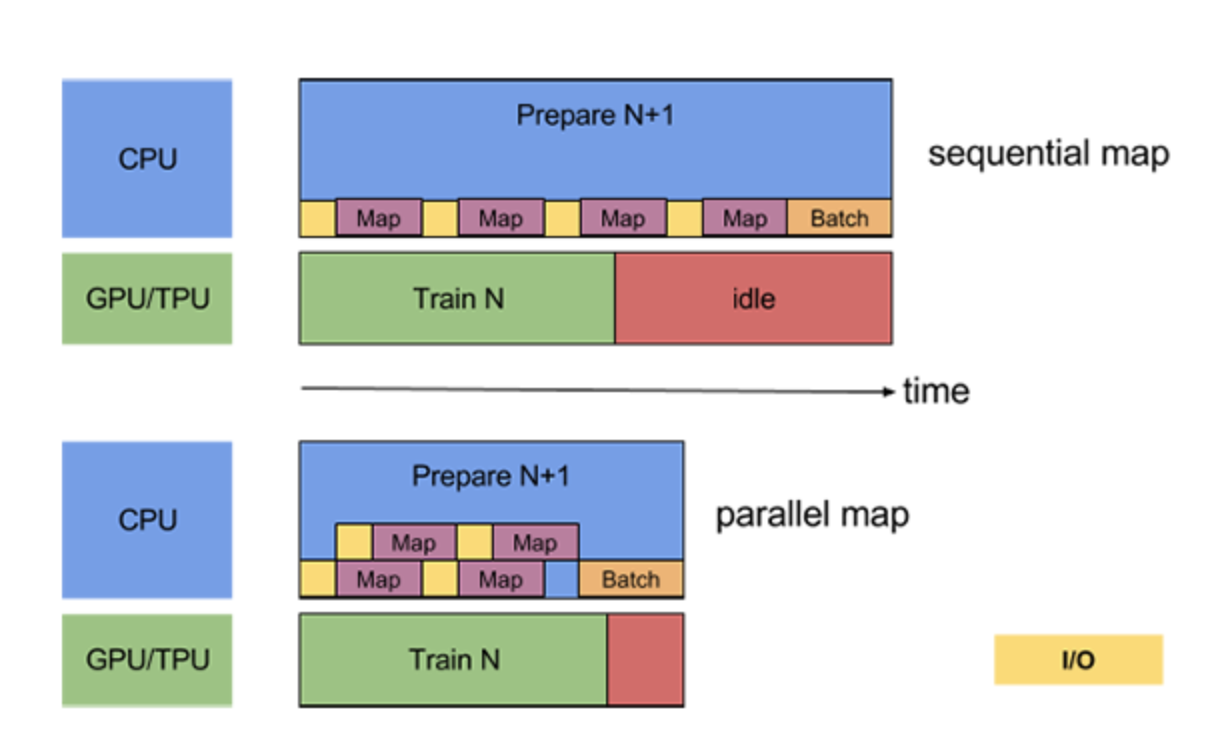

In [29]:
Image(filename='tf.data2.png')

# Flexibility

- tf.SparseTensor를 지원 (1.5ver) -> 복잡한 Categorical data나 embedding 모델을 다룰때

- Custom Python code via Dataset.from_generator() ->?

- Custom C++ code via DatasetOpKernel plugis

-> 실무 새로운 데이터셋을 만들거나 개선할때 좋다.

# Easy of Use

**더 이상 데이터를 읽고 하는데 고생할 필요가 없음**

### Use Python for loops in eager exeuction mode

```python
#Extract
files = tf.data.Dataset.list_files(file_pattern)
dataset = tf.data.TFRecordDataset(files)

#Transform
dataset = dataset.shuffle(10000)
dataset = dataset.repeat(NUM_EPOCHS)
dataset = dataset.map(lambda x: tf.parse_single_example(x, features))
dataset = dataset.batch(BATCH_SIZE)

#Eager execution make datset a normal Python iterable.

for batch in dataset:
    train_model(batch)
```

</br>

### Standard Method CSV file with protocal buffer (tf 1.8)

```python
tf.enable_eager_execution()

#make_batched_features_dataset
dataset = tf.contrib.data.make_batched_features_dataset(
    file_pattern, BATCH_SIZE, features, num_epochs=NUM_EPOCHS)

#일반적으로는 속도를 위해서는 tf.example, tfrecord와 같은 binary를 추천
#하지만 큰 데이터를 항상 가지고 있는 것은 아님.

#kaggle의 예
#$ pip install kaggle
#$ kaggle datasets downaload -d theronk/million-headlins -p .

for batch in dataset:
    train_model(batch["publish_data"], batch["headline_text"])

```

### Integration with Esitmators(and Keras comming soon!!)

```python
def input_fn():
    dataset = tf.contrib.data.make_csv_dataset(
        "*.csv", BATCH_SIZE, num_epochs=NUM_EPOCHS)
    return dataset

# train an estimator on the dataset
tf.esitmator.Estimator(model_fn=train_model).train(input_fn=input_fn)

```

추가 정보들

- www.tensorflow.org/programmers_guide/datasets
- www.tensorflow.org/performance/datasets_performance

# 실습 및 활용

https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428

1. Importing Data: 데이터셋 생성
 - From numpy
 - From tensor
 - From a placeholder
 - From generator
 
 </br>

2. Create an Iterator: 생성된 데이터셋을 바탕으로 Iterator 인스턴스를 만들기
 - One shot Iterator
 - Initializable Iterator
 - Reinitializable Iterator
 - Feedable Iterator
 
 </br>

In [2]:
import tensorflow as tf
import numpy as np

#with keras

## 1. Importing Data

In [3]:
#numpy 데이터 처리

x = np.random.sample((300,2))
print(x.shape)
# make a dataset from a numpy array
dataset = tf.data.Dataset.from_tensor_slices(x)

iter = dataset.make_one_shot_iterator()
el = iter.get_next()

with tf.Session() as sess:
    print(sess.run(el))

features, labels = (np.random.sample((100,2)), np.random.sample((100,1)))
dataset = tf.data.Dataset.from_tensor_slices((features,labels))

# Tensor Data 처리

# using a tensor
dataset = tf.data.Dataset.from_tensor_slices(tf.random_uniform([100, 2]))

# Placeholder 처리방법

x = tf.placeholder(tf.float32, shape=[None,2])
dataset = tf.data.Dataset.from_tensor_slices(x)

(300, 2)
[0.17856257 0.58724477]


In [4]:
# From generator
# generator를 활용하여 init하기 (주로 sequence와 같은 길이가 다른 element들이 있을때 유용)

sequence = np.array([[1],[2,3],[3,4]])

def generator():
    for el in sequence:
        yield el
dataset = tf.data.Dataset().from_generator(generator,
                                           output_types=tf.float32, 
                                           output_shapes=[tf.float32])

## 2. Create an Iterator - get data

### One shot Iterator

In [5]:
x = np.random.sample((100,2))
# make a dataset from a numpy array
dataset = tf.data.Dataset.from_tensor_slices(x)

# create the iterator
iter = dataset.make_one_shot_iterator()
el = iter.get_next()

with tf.Session() as sess:
    print(sess.run(el)) # output: [ 0.42116176  0.40666069]

[0.27015909 0.37339177]


### Dynamic dataset 다루기

In [6]:
# using a placeholder
x = tf.placeholder(tf.float32, shape=[None,2])
dataset = tf.data.Dataset.from_tensor_slices(x)
data = np.random.sample((100,2))

iter = dataset.make_initializable_iterator() # create the iterator

el = iter.get_next()

with tf.Session() as sess:
    # feed the placeholder with data
    sess.run(iter.initializer, feed_dict={ x: data }) 
    print(sess.run(el)) # output [ 0.52374458  0.71968478]

[0.6694058 0.6540068]


### initializable iterator to switch between dataset - 조금 더 Complex한 데이터 구조로 접근

In [7]:
EPOCHS = 10

x, y = tf.placeholder(tf.float32, shape=[None,2]), tf.placeholder(tf.float32, shape=[None,1])

dataset = tf.data.Dataset.from_tensor_slices((x, y))
train_data = (np.random.sample((100,2)), np.random.sample((100,1)))
test_data = (np.array([[1,2]]), np.array([[0]]))
iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()

with tf.Session() as sess:
    
    #     initialise iterator with train data
    sess.run(iter.initializer, feed_dict={ x: train_data[0], y: train_data[1]})
    for _ in range(EPOCHS):
        sess.run([features, labels])

    #     switch to test data
    sess.run(iter.initializer, feed_dict={ x: test_data[0], y: test_data[1]})
    print(sess.run([features, labels]))

[array([1., 2.], dtype=float32), array([0.], dtype=float32)]


In [8]:
# making fake data using numpy
train_data = (np.random.sample((100,2)), np.random.sample((100,1)))
test_data = (np.random.sample((10,2)), np.random.sample((10,1)))

# create two datasets, one for training and one for test
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
test_dataset = tf.data.Dataset.from_tensor_slices(test_data)

#Now this is the trick, we create a generic Iterator
# create a iterator of the correct shape and type

iter = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)

# and then two initialisation operations:

# create the initialisation operations
train_init_op = iter.make_initializer(train_dataset)
test_init_op = iter.make_initializer(test_dataset)

# We get the next element as before
features, labels = iter.get_next()

# Now, we can directly run the two initialisation operation using our session. Putting all together we get:
# Reinitializable iterator to switch between Datasets

### Reinitilizable Iterator - 데이터를 Dynamic하게 다룬다는 점에서 유사하지만, 새로운 데이터셋 (다른 파일을 삽입)

In [9]:
EPOCHS = 10
# making fake data using numpy
train_data = (np.random.sample((100,2)), np.random.sample((100,1)))
test_data = (np.random.sample((10,2)), np.random.sample((10,1)))
# create two datasets, one for training and one for test
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
test_dataset = tf.data.Dataset.from_tensor_slices(test_data)
# create a iterator of the correct shape and type
iter = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
features, labels = iter.get_next()
# create the initialisation operations
train_init_op = iter.make_initializer(train_dataset)
test_init_op = iter.make_initializer(test_dataset)

with tf.Session() as sess:
    sess.run(train_init_op) # switch to train dataset
    for _ in range(EPOCHS):
        sess.run([features, labels])
    sess.run(test_init_op) # switch to val dataset
    print(sess.run([features, labels]))

[array([0.40277495, 0.54851447]), array([0.57242161])]


## 3. Consuming data

In [19]:
EPOCHS = 10
BATCH_SIZE = 16
# using two numpy arrays
features, labels = (np.array([np.random.sample((100,2))]), 
                    np.array([np.random.sample((100,1))]))
dataset = tf.data.Dataset.from_tensor_slices((features,labels)).repeat().batch(BATCH_SIZE)
iter = dataset.make_one_shot_iterator()
x, y = iter.get_next()
# make a simple model
net = tf.layers.dense(x, 8, activation=tf.tanh) # pass the first value from iter.get_next() as input
net = tf.layers.dense(net, 8, activation=tf.tanh)
prediction = tf.layers.dense(net, 1, activation=tf.tanh)
loss = tf.losses.mean_squared_error(prediction, y) # pass the second value from iter.get_net() as label
train_op = tf.train.AdamOptimizer().minimize(loss)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(EPOCHS):
        _, loss_value = sess.run([train_op, loss])
        print("Iter: {}, Loss: {:.4f}".format(i, loss_value))

Iter: 0, Loss: 0.1273
Iter: 1, Loss: 0.1247
Iter: 2, Loss: 0.1223
Iter: 3, Loss: 0.1202
Iter: 4, Loss: 0.1184
Iter: 5, Loss: 0.1167
Iter: 6, Loss: 0.1152
Iter: 7, Loss: 0.1139
Iter: 8, Loss: 0.1127
Iter: 9, Loss: 0.1117


# TIPS: BATCHING / REPEAT / MAP / SHUFFLE

In [10]:
# BATCHING
BATCH_SIZE = 4
x = np.random.sample((100,2))
# make a dataset from a numpy array
dataset = tf.data.Dataset.from_tensor_slices(x).batch(BATCH_SIZE)

iter = dataset.make_one_shot_iterator()
el = iter.get_next()

with tf.Session() as sess:
    print(sess.run(el))

[[0.59718665 0.89988339]
 [0.88266584 0.91656019]
 [0.84153486 0.9416401 ]
 [0.41580571 0.67149192]]


In [30]:
# REPEAT
BATCH_SIZE = 4
x = np.array([[1],[2],[3],[4]])
# make a dataset from a numpy array
dataset = tf.data.Dataset.from_tensor_slices(x)
dataset = dataset.repeat()

iter = dataset.make_one_shot_iterator()
el = iter.get_next()

with tf.Session() as sess:
#     this will run forever
    while True:
        print(sess.run(el))

[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]


[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]


[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]


[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]
[3]
[4]
[1]
[2]


KeyboardInterrupt: 

In [11]:
# MAP
x = np.array([[1],[2],[3],[4]])
# make a dataset from a numpy array
dataset = tf.data.Dataset.from_tensor_slices(x)
dataset = dataset.map(lambda x: x*2)

iter = dataset.make_one_shot_iterator()
el = iter.get_next()

with tf.Session() as sess:
#     this will run forever
        for _ in range(len(x)):
            print(sess.run(el))

[2]
[4]
[6]
[8]


In [12]:
# SHUFFLE
BATCH_SIZE = 4
x = np.array([[1],[2],[3],[4]])
# make a dataset from a numpy array
dataset = tf.data.Dataset.from_tensor_slices(x)
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(BATCH_SIZE)

iter = dataset.make_one_shot_iterator()
el = iter.get_next()

with tf.Session() as sess:
    print(sess.run(el))

[[2]
 [4]
 [3]
 [1]]
